In [120]:
"""captum vis"""

import pickle
import random
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization
# data_path = '../result/interpret/cn_novel_5billion_cn_novel_5billion_cn_roberta_debug_0_text_len_512_True_vis_record.pkl'
# data_path = '/home/iamlxb3/temp_rsync_dir/story_turing_test/result/interpret/imdb_test_vis_record.pkl'
data_path = '/home/iamlxb3/temp_rsync_dir/story_turing_test/result/interpret/en_grover_interpret_en_grover_en_roberta_debug_1_text_len_20_True_vis_record.pkl'

data = pickle.load(open(data_path, 'rb'))
print("data size: ", len(data))

sample_data = random.sample(data, min(len(data), 20))
_ = visualization.visualize_text(sample_data)

data size:  50


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.54),label,-0.51,"The US State Department called the sanctions against the three firms an "" important "" step in convincing"
1,1 (0.54),label,-1.08,"A group of artists , film arch iv ists , and educators sued after an international treaty signed"
1,1 (0.54),label,-1.53,"In light of what has been a long and tumultuous political season , here are my strongest arguments"
1,1 (0.54),label,-0.77,But here is what we do know : . 1 . She 's a well - respected attorney
1,1 (0.54),label,0.34,president : George Washington . First human to walk on the moon : Neil Armstrong . First to
1,1 (0.54),label,-1.73,"The child 's grandmother was frantic , talking a mile a minute . But her mother seemed un"
1,1 (0.54),label,-1.60,".. intervene quite radically and effectively and immediately ."" Since the outbreak started in March , about 9"
1,1 (0.54),label,-0.61,"They are just like any other group of employees -- wildly diverse in their actions , thoughts ,"
1,1 (0.54),label,-0.45,"This "" new "" debate actually reflects a question policymakers have asked for several decades : Does job"
1,1 (0.54),label,0.61,"The shirt less man explodes forward once more , from standing , shooting ag ress ively into the"


pos_df_avg_attr:  0.022943498497021948
neg_df_avg_attr:  -0.02774758708342908
(5995, 6)
Token:  ，


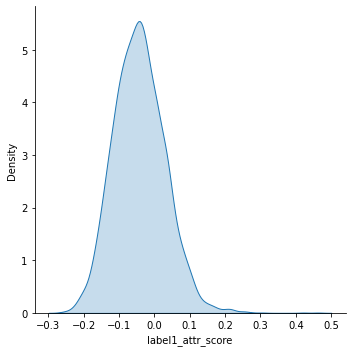

(2804, 6)
Token:  的


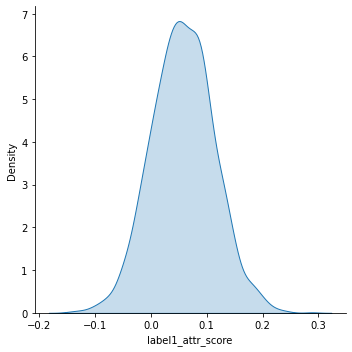

In [16]:
"""attr dis vis"""

import pandas as pd
import numpy as np
import collections
import pdb
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../result/interpret/cn_novel_5billion_cn_novel_5billion_cn_roberta_debug_0_text_len_512_True_token_attr.csv')
tokens = collections.Counter(df['token'].values)
label = 0
keep_N = 2
tokens_counter = sorted(collections.Counter(tokens).items(), key=lambda x:x[1], reverse=True)
pos_df_avg_attr = np.average(df[df['label']==1]['label1_attr_score'].values)
neg_df_avg_attr = np.average(df[df['label']==0]['label1_attr_score'].values)

print('pos_df_avg_attr: ', pos_df_avg_attr)
print('neg_df_avg_attr: ', neg_df_avg_attr)

for token, freq in tokens_counter[:keep_N]:
    token_df = df[(df['token']==token) & (df['label']==label)]
    # attr_score = token_df['label1_attr_score'].values
    print(token_df.shape)
    sns.displot(token_df, x="label1_attr_score", kind="kde", fill=True)
    print('Token: ', token)
    # plt.axvline(pos_df_avg_attr, 0, 5)
    plt.show()
    # pdb.set_trace()

Save plot df to ../result/interpret/temp/interpret_cn_novel_5billion_cn_roberta_debug_0_text_len_128_debug_N_500_use_pad_bs_token_attr_X_attr_200_pos.csv


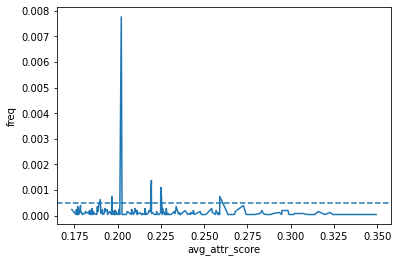

Save plot df to ../result/interpret/temp/interpret_cn_novel_5billion_cn_roberta_debug_0_text_len_128_debug_N_500_use_pad_bs_token_attr_X_attr_200_neg.csv


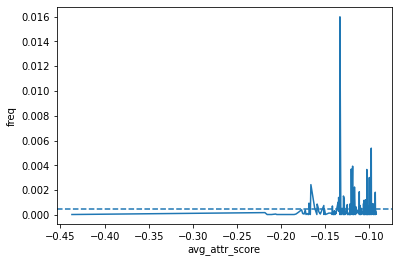

In [6]:
"""
attr dis vis
sort attr from low to high
"""
import os
import ntpath
import pandas as pd
import numpy as np
import collections
import pdb
import seaborn as sns
import matplotlib.pyplot as plt

# TODO, PLOT IDF
prefix = 'X_attr'
path = '../result/interpret/interpret_cn_novel_5billion_cn_roberta_debug_0_text_len_128_debug_N_500_use_pad_bs_token_attr.csv'
df = pd.read_csv(path)
df = pd.read_csv(path)
basename = ntpath.basename(path).split('.')[0]
tokens = collections.Counter(df['token'].values)
pos_df = df[df['label']==1]
neg_df = df[df['label']==0]
keep_N = 200

def plot_df(pos_df, keep_N, is_neg):
    
    if not is_neg:
        plot_df_path = os.path.join('../result/interpret/temp', f'{basename}_{prefix}_{keep_N}_pos.csv')
    else:
        plot_df_path = os.path.join('../result/interpret/temp', f'{basename}_{prefix}_{keep_N}_neg.csv')
    
    pos_df_counter = collections.Counter(pos_df['token'].values)
    total_count = np.sum(list(pos_df_counter.values()))
    pos_df_counter = {k: v / total_count for k, v in pos_df_counter.items()}
    avg_ratio = np.average(list(pos_df_counter.values()))
        
    if os.path.isfile(plot_df_path):
        plot_df = pd.read_csv(plot_df_path)
        print(f"read plot df from {plot_df_path}")
    else:

        pos_token_attr_score = collections.defaultdict(lambda: [])
        for i, row in pos_df.iterrows():
            token = row['token']
            attr_score = row['label1_attr_score']
            pos_token_attr_score[token].append(attr_score) 
            # if is_neg:
            #     if attr_score < 0.0:
            #         pos_token_attr_score[token].append(attr_score) 
            # else:
            #     if attr_score > 0.0:
            #         pos_token_attr_score[token].append(attr_score) 

        pos_token_attr_score = {k: np.average(v) for k, v in pos_token_attr_score.items()}

        if is_neg:
            pos_token_attr_score = sorted(pos_token_attr_score.items(), key=lambda x: x[1], reverse=False)[:keep_N]
        else:
            pos_token_attr_score = sorted(pos_token_attr_score.items(), key=lambda x: x[1], reverse=True)[:keep_N]

        plot_df = {'token': [], 'avg_attr_score': [], 'freq': []}
        for token, avg_attr_score in pos_token_attr_score:
            plot_df['token'].append(token)
            plot_df['avg_attr_score'].append(avg_attr_score)
            plot_df['freq'].append(pos_df_counter[token])

        plot_df = pd.DataFrame(plot_df)
        plot_df.to_csv(plot_df_path, index=False)
        print(f"Save plot df to {plot_df_path}")

    ax = sns.lineplot(data=plot_df, x="avg_attr_score", y="freq")
    ax.axhline(avg_ratio, ls='--')
    plt.show()

plot_df(pos_df, keep_N, False)
plot_df(neg_df, keep_N, True)

In [ ]:
"""
attr dis vis
sort freq from high to low
"""
import os
import pandas as pd
from tqdm import tqdm
import ntpath
import numpy as np
import collections
import pdb
import seaborn as sns
import matplotlib.pyplot as plt

prefix = 'X_freq'
path = '../result/interpret/cn_novel_5billion_cn_novel_5billion_cn_roberta_debug_0_text_len_512_True_token_attr.csv'
df = pd.read_csv(path)
basename = ntpath.basename(path).split('.')[0]
tokens = collections.Counter(df['token'].values)
pos_df = df[df['label']==1]
neg_df = df[df['label']==0]
keep_N = 500

def plot_df(pos_df, keep_N, is_pos=True, is_top=True):
    
    if is_pos:
        plot_df_path = os.path.join('../result/interpret/temp', f'{basename}_{prefix}_{keep_N}_{is_top}_pos.csv')
    else:
        plot_df_path = os.path.join('../result/interpret/temp', f'{basename}_{prefix}_{keep_N}_{is_top}_neg.csv')
    
    if os.path.isfile(plot_df_path):
        plot_df = pd.read_csv(plot_df_path)
        print(f"read plot df from {plot_df_path}")
    else:
        pos_df_counter = collections.Counter(pos_df['token'].values)
        total_count = np.sum(list(pos_df_counter.values()))
        pos_df_counter = {k: v / total_count for k, v in pos_df_counter.items()}

        pos_token_attr_score = collections.defaultdict(lambda: [])
        for i, row in pos_df.iterrows():
            token = row['token']
            attr_score = row['label1_attr_score']
            if is_pos:
                if attr_score > 0.0:
                    pos_token_attr_score[token].append(attr_score)
            else:
                if attr_score < 0.0:
                    pos_token_attr_score[token].append(attr_score)
        pos_token_attr_score = {k: np.average(v) for k, v in pos_token_attr_score.items()}

        freq_attr_dict = collections.defaultdict(lambda: [])
        for token, freq in pos_df_counter.items():
            if token in pos_token_attr_score:
                freq_attr_dict[f'{freq:.6f}'].append(pos_token_attr_score[token])
        freq_attr_dict = {float(k): np.average(v) for k, v in freq_attr_dict.items()}
        print("freq_attr_dict len: ", len(freq_attr_dict))
        freq_attr = sorted(freq_attr_dict.items(), key=lambda x:x[0], reverse=is_top)[:keep_N]
        plot_df = {'freq': [x[0] for x in freq_attr], 'avg_attr_score': [x[1] for x in freq_attr]}
        plot_df = pd.DataFrame(plot_df)
        plot_df.to_csv(plot_df_path, index=False)
        print(f"Save plot df to {plot_df_path}")
    
    avg_attr_score = plot_df['avg_attr_score'].mean()
    print("plot_df: ", plot_df.shape)
    plot_df['avg_attr_score_smooth'] = plot_df['avg_attr_score'].rolling(window=20).mean()
    ax = sns.lineplot(data=plot_df, x="freq", y="avg_attr_score_smooth", marker='o')
    ax.axhline(avg_attr_score, ls='--')
    plt.show()

plot_df(pos_df, keep_N, is_pos=True)
#plot_df(pos_df, keep_N, is_pos=True, is_top=False)
plot_df(neg_df, keep_N, is_pos=False)
#plot_df(neg_df, keep_N, is_pos=False, is_top=False)

KeyboardInterrupt: 

pos_df: (497655, 7)
neg_df: (540777, 7)


100%|██████████| 4666/4666 [00:31<00:00, 147.59it/s]


pos_df_counter:  4086
Save plot df to ../result/interpret/temp/interpret_cn_novel_5billion_cn_roberta_debug_0_text_len_128_debug_N_10000_use_all_zero_bs_token_attr_joint_plot_3881_False_freq_pos.csv


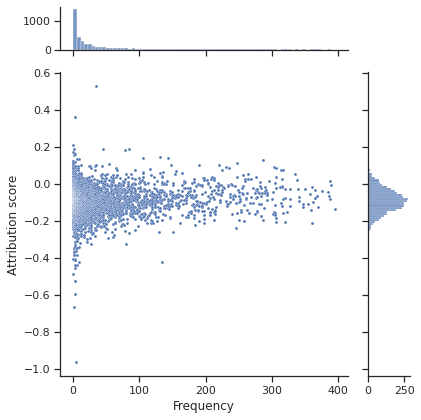

100%|██████████| 4980/4980 [00:34<00:00, 145.16it/s]


pos_df_counter:  4387
Save plot df to ../result/interpret/temp/interpret_cn_novel_5billion_cn_roberta_debug_0_text_len_128_debug_N_10000_use_all_zero_bs_token_attr_joint_plot_4167_False_freq_neg.csv


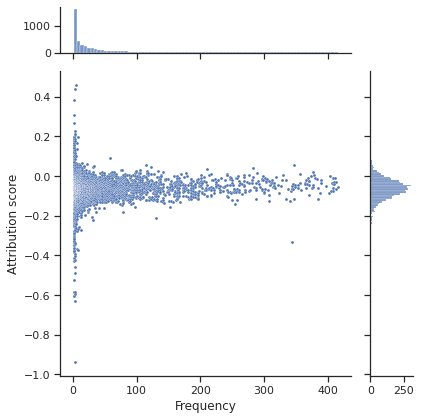

In [163]:
"""
attr dis joint plot
"""
import pandas as pd
import numpy as np
import collections
import pdb
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

prefix = 'joint_plot'

# cn_novel_5billion
dataset_name='cn_novel_5billion'
#path = '../result/interpret/interpret_cn_novel_5billion_cn_roberta_debug_0_text_len_128_debug_N_10000_use_pad_bs_token_attr.csv'
path = '../result/interpret/interpret_cn_novel_5billion_cn_roberta_debug_0_text_len_128_debug_N_10000_use_all_zero_bs_token_attr.csv'
idf_path = '../result/static_data_analysis/cn_novel_5billion_hfl_chinese_roberta_wwm_ext_idf.csv'
keep_N = None

# # en_grover
# dataset_name='en_grover'
# # path = '../result/interpret/interpret_en_grover_en_roberta_debug_0_text_len_256_debug_N_10000_use_pad_bs_token_attr.csv'
# path = '../result/interpret/interpret_en_grover_en_roberta_debug_0_text_len_256_debug_N_10000_use_all_zero_bs_token_attr.csv'
# idf_path = '../result/static_data_analysis/en_grover_roberta_base_idf.csv'
# keep_N = None

# # en_writing_prompt
# dataset_name='en_writing_prompt'
# # path = '../result/interpret/interpret_en_writing_prompt_en_roberta_debug_0_text_len_128_debug_N_10000_use_pad_bs_token_attr.csv'
# path = '../result/interpret/interpret_en_writing_prompt_en_roberta_debug_0_text_len_128_debug_N_10000_use_all_zero_bs_token_attr.csv'
# idf_path = '../result/static_data_analysis/en_writing_prompt_roberta_base_idf.csv'
# keep_N = None

idf_df = pd.read_csv(idf_path)
# pdb.set_trace()
idf_dict = dict(zip(idf_df.token, idf_df.idf))
use_value = 'freq' # freq, idf, tfidf, concretness

df = pd.read_csv(path)
basename = ntpath.basename(path).split('.')[0]

tokens = collections.Counter(df['token'].values)
pos_df = df[df['label']==1]
neg_df = df[df['label']==0]
print(f"pos_df: {pos_df.shape}")
print(f"neg_df: {neg_df.shape}")

# read concretness dict
concreteness = pd.read_csv('../static/Concreteness_ratings_Brysbaert_et_al_BRM.csv')
words_concreteness = dict(zip(concreteness['Word'].values, concreteness['Conc.M'].values))


def plot_df(pos_df, keep_N, is_pos=True, is_top=True):
    
    unique_token_N = len(set(pos_df['token'].values))
    
    if keep_N is None:
        keep_N = int(unique_token_N * 0.95)
    
    if is_pos:
        plot_df_path = os.path.join('../result/interpret/temp', f'{basename}_{prefix}_{keep_N}_{is_top}_{use_value}_pos.csv')
    else:
        plot_df_path = os.path.join('../result/interpret/temp', f'{basename}_{prefix}_{keep_N}_{is_top}_{use_value}_neg.csv')
    
    if os.path.isfile(plot_df_path):
        plot_df = pd.read_csv(plot_df_path)
        print(f"read plot df from {plot_df_path}")
    else:
        plot_df = {'freq': [], 'attr_score': []}
        
        token_per_sen_score = collections.defaultdict(lambda: [])
        # ----------------------------------------------------------------------------------------------------------
        # compute per sentence attr score
        # ----------------------------------------------------------------------------------------------------------
        all_sen_i = set(pos_df['sen_i'].values)
        for sen_i, sen_df in tqdm(pos_df.groupby('sen_i'), total=len(all_sen_i)):
            per_sen_score = collections.defaultdict(lambda: 0)
            
            for i, row in sen_df.iterrows():
                token = row['token']
                token_attr_score = row['label1_attr_score']
                
                score_valid = True # todo
                # if is_pos:
                #     if token_attr_score > 0.0:
                #         score_valid = True
                # else:
                #     if token_attr_score < 0.0:
                #         score_valid = True
                
                if score_valid:
                    per_sen_score[token] += token_attr_score
            
            for token, score in per_sen_score.items():
                token_per_sen_score[token].append(score)
        token_per_sen_score = {k:np.average(v) for k,v in token_per_sen_score.items()}
        sort_token_per_sen_score = sorted(token_per_sen_score.items(), key=lambda x:x[1], reverse=True)
        # -----------------------------------------------------
        
        pos_df_counter = collections.Counter(pos_df['token'].values)
        # if not is_top:
        #     pos_df_counter = {k: v for k, v in pos_df_counter.items() if v >= 10}
        total_count = np.sum(list(pos_df_counter.values()))
        # pos_df_counter = {k: v / total_count for k, v in pos_df_counter.items()}
        print("pos_df_counter: ", len(pos_df_counter))
        # pdb.set_trace()
        pos_df_counter = sorted(pos_df_counter.items(), key=lambda x:x[1], reverse=is_top)[:keep_N]
        
        # pos_token_attr_score = collections.defaultdict(lambda: [])
        # for i, row in pos_df.iterrows():
        #     token = row['token']
        #     attr_score = row['label1_attr_score']
        #     if is_pos:
        #         if attr_score > 0.0:
        #             pos_token_attr_score[token].append(attr_score)
        #     else:
        #         if attr_score < 0.0:
        #             pos_token_attr_score[token].append(attr_score)
        # pos_token_attr_score = {k: np.average(v) for k, v in pos_token_attr_score.items()}
        plot_df = {'freq': [], 'attr_score': []}
        for token, freq in pos_df_counter:
            if token in token_per_sen_score:
                if use_value == 'freq':
                    plot_df['freq'].append(freq)
                elif use_value == 'idf':
                    plot_df['freq'].append(idf_dict[token])
                elif use_value == 'tfidf':
                    plot_df['freq'].append(idf_dict[token] * freq)
                elif use_value == 'concretness':
                    concretness = words_concreteness.get(token, 0.0)
                    if concretness > 0.0:
                        plot_df['freq'].append(concretness)
                else:
                    raise Exception
                
                if use_value == 'concretness':
                    if concretness > 0.0:
                        plot_df['attr_score'].append(token_per_sen_score[token])
                else:
                    plot_df['attr_score'].append(token_per_sen_score[token])
        plot_df = pd.DataFrame(plot_df)
        plot_df.to_csv(plot_df_path, index=False)
        print(f"Save plot df to {plot_df_path}")
    # sort_plot_df = plot_df.sort_values(by='attr_score', ascending=cending=False)
    # pdb.set_trace()
    plot_df['Attribution score'] = plot_df['attr_score']
    plot_df['Frequency'] = plot_df['freq']

    #plot_df = plot_df.rename(columns={'attr_score': 'attr_score2'}, inplace=True)
    # df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)
    ax = sns.jointplot(data=plot_df, x="Frequency", y="Attribution score", marginal_ticks=True, s=9)
    # ax = sns.jointplot(data=pd.DataFrame(plot_df), x="freq", y="attr_score", marginal_ticks=True)
    # ax.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
    # ax.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    plt.tight_layout()
    if is_pos:
        plt.savefig(f'../vis/interpret_freq_attr_score_pos_{dataset_name}.pdf')
    else:
        plt.savefig(f'../vis/interpret_freq_attr_score_neg_{dataset_name}.pdf')
    plt.show()

#plot_df(pos_df, keep_N, is_pos=True)
plot_df(pos_df, keep_N, is_pos=True, is_top=False)
#plot_df(neg_df, keep_N, is_pos=False)
plot_df(neg_df, keep_N, is_pos=False, is_top=False)

pos_df: (500, 8)
neg_df: (500, 8)


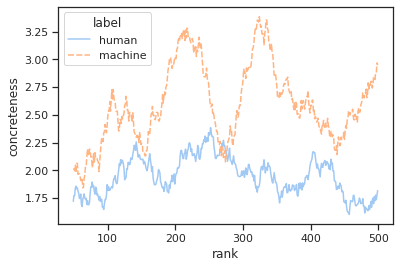

In [153]:
"""
N-gram concreteness
"""
import pandas as pd
import numpy as np
import collections
import pdb
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

prefix = 'joint_plot'
target_gram = 1 # 1,3,5
keep_N = 500
window_size=50

# cn novel
# target_dir = '../result/interpret/ngram/interpret_cn_novel_5billion_cn_roberta_debug_0_text_len_128_debug_N_10000_use_all_zero_bs'

# en_grover
# target_dir = '../result/interpret/ngram/interpret_en_grover_en_roberta_debug_0_text_len_256_debug_N_10000_use_all_zero_bs'

# en_writing_prompt
target_dir = '../result/interpret/ngram/interpret_en_writing_prompt_en_roberta_debug_0_text_len_128_debug_N_10000_use_all_zero_bs'

pos_df = pd.read_csv(os.path.join(target_dir, f'ngram-{target_gram}_pos_attr.csv'))[:keep_N]
neg_df = pd.read_csv(os.path.join(target_dir, f'ngram-{target_gram}_neg_attr.csv'))[:keep_N]

# pos_df = pos_df[pos_df['concreteness'] > 0.0][:keep_N].reset_index()
# neg_df = neg_df[neg_df['concreteness'] > 0.0][:keep_N].reset_index()

pos_df['concreteness'] = pos_df['concreteness'].rolling(window=window_size).mean()
neg_df['concreteness'] = neg_df['concreteness'].rolling(window=window_size).mean()
pos_df['label'] = 'human'
pos_df['rank'] = pos_df.index
neg_df['label'] = 'machine'
neg_df['rank'] = neg_df.index

print(f"pos_df: {pos_df.shape}")
print(f"neg_df: {neg_df.shape}")

plot_df = pd.concat([pos_df, neg_df])
plot_df = plot_df.reset_index()
# print(plot_df)
ax = sns.lineplot(data=plot_df, x="rank", y="concreteness", hue='label', style='label', palette = 'pastel')

plt.savefig(f'../vis/interpret_concret_ngram_{target_gram}_{dataset_name}.pdf')

plt.show()